# Phase 4 — Attack Reconstruction Module (phase4.ipynb)

Implements **two** reconstruction methods:
- **Method B**: Attention-Based Event Linkage
- **Method D**: Graph Reconstruction Using Predicted Correlations

Saves required outputs to `results/reconstruction/`:
- `reconstructed_chains.json`
- `chain_1_timeline.png`
- `chain_1_graph.png`


In [ ]:
# Cell 1 — Imports
from pathlib import Path
import os, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F


In [8]:
# Cell 2 — Directory conventions (same style as phases 1–3)
HERE = Path.cwd().resolve()
PROJECT_DIR = HERE.parent if HERE.name.lower() in {"notebooks", "notebook"} else HERE

DATA_DIR = PROJECT_DIR / "data"
RAW_DIR  = DATA_DIR / "raw"
OUT_DIR  = DATA_DIR / "out"
PREP_DIR = DATA_DIR / "processed"

MODELS_DIR  = PROJECT_DIR / "models"
RESULTS_DIR = PROJECT_DIR / "results"
RECON_DIR   = RESULTS_DIR / "reconstruction"

for d in [RAW_DIR, OUT_DIR, PREP_DIR, MODELS_DIR, RESULTS_DIR, RECON_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("RAW_DIR:", RAW_DIR)
print("PREP_DIR:", PREP_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("RECON_DIR:", RECON_DIR)


PROJECT_DIR: D:\INS\Assignment_2
RAW_DIR: D:\INS\Assignment_2\data\raw
PREP_DIR: D:\INS\Assignment_2\data\processed
MODELS_DIR: D:\INS\Assignment_2\models
RECON_DIR: D:\INS\Assignment_2\results\reconstruction


In [10]:
# Cell 3 — Load sequences (Phase 1 outputs) + reconstruct original train/test indices
# IMPORTANT: This reconstructs which original window each X_train/X_test row came from,
# so we can map model outputs back to global event_ids correctly.

from sklearn.model_selection import GroupShuffleSplit

SEQ_LEN = 100  # MUST match Phase 1 / Phase 3
npz_path = PREP_DIR / f"sequences_len{SEQ_LEN}.npz"
groups_path = PREP_DIR / f"seq_groups_len{SEQ_LEN}.npy"
last_ids_path = PREP_DIR / f"seq_last_event_id_len{SEQ_LEN}.npy"

assert npz_path.exists(), f"Missing {npz_path}. Re-run Phase 1 last cells."
assert groups_path.exists(), f"Missing {groups_path}. Re-run Phase 1 last cells."
assert last_ids_path.exists(), f"Missing {last_ids_path}. Re-run Phase 1 last cells."

npz = np.load(npz_path, allow_pickle=True)
X_train = npz["X_train"]; X_test = npz["X_test"]
m_train = npz["m_train"]; m_test = npz["m_test"]
y_train = npz["y_train"]; y_test = npz["y_test"]

seq_groups = np.load(groups_path, allow_pickle=True).astype(str)
seq_last_event_id = np.load(last_ids_path, allow_pickle=True)

N = len(seq_groups)
print("Total windows N:", N)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

# Reproduce same session-aware split used earlier (GroupShuffleSplit)
idx = np.arange(N)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(idx, groups=seq_groups))

assert len(train_idx) == len(X_train) and len(test_idx) == len(X_test), (
    "Split mismatch: if Phase 1 used a different split method/random_state, "
    "you must reuse the same indices here."
)

print("train_idx:", len(train_idx), "test_idx:", len(test_idx))


Total windows N: 100000
X_train: (80000, 100, 112) X_test: (20000, 100, 112)
train_idx: 80000 test_idx: 20000


In [11]:
# Cell 4 — Load chronological events table (preferred: parquet from Phase 1; fallback: rebuild from raw)

# Preferred: parquet saved from Phase 1
candidates = [PREP_DIR / "events_table.parquet", PREP_DIR / "unified_events.parquet"]
df = None
for p in candidates:
    if p.exists():
        df = pd.read_parquet(p)
        print("Loaded:", p)
        break

# Fallback: rebuild from raw dataset file in RAW_DIR
if df is None:
    raw_files = list(RAW_DIR.rglob("*.jsonl")) + list(RAW_DIR.rglob("*.csv"))
    assert raw_files, f"No raw files found in {RAW_DIR}. Put dataset files there then re-run."
    src = raw_files[0]
    print("Rebuilding df from:", src)

    if src.suffix.lower() == ".jsonl":
        df = pd.read_json(src, lines=True)
    else:
        df = pd.read_csv(src)

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

# Ensure required columns exist (create if missing)
for col in ["event_id","host","src_ip","dst_ip","user","event_type","meta_session_id"]:
    if col not in df.columns:
        df[col] = pd.NA

df = df.sort_values("timestamp").reset_index(drop=True)
print("df shape:", df.shape)
df[["event_id","timestamp","host","src_ip","dst_ip","user","event_type"]].head()


Loaded: D:\INS\Assignment_2\data\processed\unified_events.parquet
df shape: (100000, 47)


,event_id,timestamp,host,src_ip,dst_ip,user,event_type
0,8f7b1e90-e534-4a0b-b273-c58ce683dafe,2020-07-12 21:38:20+00:00,unknown,197.198.51.199,182.162.163.189,bsmith,firewall
1,168ca1a1-e358-41d5-95e2-a0c747c6bc22,2020-07-14 14:15:20+00:00,unknown,33.122.86.82,38.74.223.35,bsmith,network
2,77713c17-6a3d-40fc-a824-de4addaaf692,2020-07-15 12:06:45+00:00,unknown,0.0.0.0,0.0.0.0,smithheather,cloud
3,c1ceab28-b9a7-4ff2-9f7e-d6bfa9a506dc,2020-07-16 17:35:06+00:00,unknown,0.0.0.0,0.0.0.0,parkerandre,endpoint
4,a8bba9b0-994c-4bc9-b614-fbabfc4d3512,2020-07-16 20:16:05+00:00,unknown,196.184.140.85,193.254.63.79,bsmith,network


In [12]:
# Cell 5 — Recreate window -> event_id mapping (same sessionization/windowing as Phase 1)
# This creates seq_event_ids in the ORIGINAL window order (index 0..N-1).

SESSION_COL = "meta_session_id" if "meta_session_id" in df.columns else "host"
STRIDE = SEQ_LEN  # If Phase 1 used overlap, set stride accordingly (e.g., SEQ_LEN//2)

df_sess = df.dropna(subset=[SESSION_COL]).copy()
df_sess[SESSION_COL] = df_sess[SESSION_COL].astype(str)

sess_to_ids = (
    df_sess.sort_values(["timestamp"])
          .groupby(SESSION_COL)["event_id"]
          .apply(list)
          .to_dict()
)

seq_event_ids = []
for sid, ids in sess_to_ids.items():
    for start in range(0, len(ids), STRIDE):
        win = ids[start:start+SEQ_LEN]
        if len(win) < SEQ_LEN:
            win = win + [None]*(SEQ_LEN-len(win))
        seq_event_ids.append(win)

seq_event_ids = np.array(seq_event_ids, dtype=object)
print("Built windows:", len(seq_event_ids), "| expected N:", N)

assert len(seq_event_ids) == N, (
    "Window count mismatch. Ensure SESSION_COL/STRIDE/SEQ_LEN match Phase 1 exactly."
)

seq_event_ids_test = seq_event_ids[test_idx]  # aligns with X_test rows


Built windows: 100000 | expected N: 100000


In [17]:
# Cell 6 — Load Transformer Model 1 (MATCHES your checkpoint: cls + pos(3D) + self_attn + head[LayerNorm, Linear])

from pathlib import Path
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- 1) Locate model1 checkpoint ----------
PHASE3_DIR = RESULTS_DIR / "phase3"
SEARCH_DIRS = [PHASE3_DIR, MODELS_DIR]

candidates = []
for d in SEARCH_DIRS:
    if d.exists():
        candidates += sorted(d.rglob("model1_best.pt"))
        candidates += sorted(d.rglob("model1_best.pth"))
        candidates += sorted(d.rglob("model1*.pt"))
        candidates += sorted(d.rglob("model1*.pth"))

assert candidates, f"No model1 weights found. Checked: {[str(d) for d in SEARCH_DIRS]}"
MODEL1_PATH = candidates[0]
print("Using MODEL1_PATH:", MODEL1_PATH)

# ---------- 2) Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---------- 3) Load checkpoint -> state_dict ----------
ckpt = torch.load(MODEL1_PATH, map_location="cpu")

def extract_state_dict(obj):
    if isinstance(obj, dict):
        for k in ["state_dict", "model_state_dict", "model", "net", "weights"]:
            if k in obj and isinstance(obj[k], dict):
                return obj[k]
        if all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
    if hasattr(obj, "state_dict"):
        return obj.state_dict()
    raise TypeError("Checkpoint format not recognized.")

state_dict = extract_state_dict(ckpt)
state_dict = {(k[7:] if k.startswith("module.") else k): v for k, v in state_dict.items()}

print("Example keys:", list(state_dict.keys())[:12])

# ---------- 4) Infer core dims ----------
in_dim = int(X_train.shape[-1])

assert "proj.weight" in state_dict, "Expected 'proj.weight' in checkpoint."
d_model = int(state_dict["proj.weight"].shape[0])

# num_layers
layer_idxs = []
for k in state_dict.keys():
    m = re.match(r"layers\.(\d+)\.", k)
    if m:
        layer_idxs.append(int(m.group(1)))
num_layers = (max(layer_idxs) + 1) if layer_idxs else 1

# pos buffer shape MUST match checkpoint
assert "pos" in state_dict, "Expected 'pos' in checkpoint."
pos_tensor = state_dict["pos"]
pos_shape = tuple(pos_tensor.shape)   # e.g., (1, 101, 128)
if len(pos_shape) == 3:
    max_len = int(pos_shape[1])
elif len(pos_shape) == 2:
    max_len = int(pos_shape[0])
else:
    raise ValueError(f"Unexpected pos shape: {pos_shape}")

# head.0 is LayerNorm (1D weight), head.1 is Linear (2D weight)
assert "head.0.weight" in state_dict and "head.1.weight" in state_dict, "Expected head.0/head.1 in checkpoint."
assert state_dict["head.0.weight"].dim() == 1, "head.0.weight should be 1D (LayerNorm)."
assert state_dict["head.1.weight"].dim() == 2, "head.1.weight should be 2D (Linear)."
num_classes = int(state_dict["head.1.weight"].shape[0])

print(f"Inferred -> in_dim={in_dim}, d_model={d_model}, num_layers={num_layers}, pos_shape={pos_shape}, max_len={max_len}, num_classes={num_classes}")

# ---------- 5) Recover nhead (prefer tuning CSV if available) ----------
def pick_nhead(phase3_dir: Path, d_model: int):
    csv_path = phase3_dir / "model1_tuning_results.csv"
    if csv_path.exists():
        df_t = pd.read_csv(csv_path)
        # pick best row if possible, else last row
        score_cols = [c for c in df_t.columns if c.lower() in {"val_f1","val_macro_f1","macro_f1","f1","best_score","score"}]
        row = df_t.iloc[df_t[score_cols[0]].astype(float).idxmax()] if score_cols else df_t.iloc[-1]
        for cand in ["nhead","num_heads","heads"]:
            if cand in df_t.columns:
                h = int(row[cand])
                if d_model % h == 0:
                    return h

    # fallback: any divisor of d_model
    for h in [8, 4, 2, 1]:
        if d_model % h == 0:
            return h
    return 1

nhead = pick_nhead(PHASE3_DIR, d_model)
assert d_model % nhead == 0, f"Invalid nhead={nhead} for d_model={d_model}"
print("Using nhead:", nhead)

# ---------- 6) Detect FFN weight paths inside layers.0 (we don't assume linear1/linear2 names) ----------
def detect_ffn_paths(sd: dict, d_model: int, layer_idx: int = 0):
    prefix = f"layers.{layer_idx}."
    wkeys = [k for k in sd.keys()
             if k.startswith(prefix) and k.endswith(".weight")
             and ".self_attn." not in k
             and ".norm" not in k]

    mats = []
    for k in wkeys:
        W = sd[k]
        if isinstance(W, torch.Tensor) and W.dim() == 2:
            path = k[len(prefix):-len(".weight")]
            mats.append((path, tuple(W.shape)))

    if not mats:
        raise KeyError(f"Could not find FFN matrices under {prefix}* excluding self_attn/norm.")

    # pick first FF: (dim_ff, d_model)
    ff1_candidates = [m for m in mats if m[1][1] == d_model and m[1][0] != d_model]
    if not ff1_candidates:
        ff1_candidates = [m for m in mats if m[1][1] == d_model]
    ff1_path, ff1_shape = sorted(ff1_candidates, key=lambda x: x[1][0], reverse=True)[0]
    dim_ff = int(ff1_shape[0])

    # pick second FF: (d_model, dim_ff)
    ff2_candidates = [m for m in mats if m[1] == (d_model, dim_ff)]
    if not ff2_candidates:
        raise KeyError(f"Could not find second FFN matrix with shape {(d_model, dim_ff)}. Found: {mats}")
    ff2_path, _ = ff2_candidates[0]

    ff1_bias = f"{prefix}{ff1_path}.bias" in sd
    ff2_bias = f"{prefix}{ff2_path}.bias" in sd
    return ff1_path, ff2_path, dim_ff, ff1_bias, ff2_bias

ff1_path, ff2_path, dim_ff, ff1_bias, ff2_bias = detect_ffn_paths(state_dict, d_model, layer_idx=0)
print("Detected FFN paths:", ff1_path, "->", ff2_path, "| dim_ff:", dim_ff)

# ---------- 7) Build modules by dotted path (so state_dict keys match) ----------
def set_by_path(root: nn.Module, path: str, module: nn.Module):
    parts = path.split(".")
    cur = root
    for i, part in enumerate(parts[:-1]):
        nxt = parts[i+1]
        if not hasattr(cur, part):
            setattr(cur, part, nn.ModuleDict() if nxt.isdigit() else nn.Module())
        cur = getattr(cur, part)
        if isinstance(cur, nn.ModuleDict) and (nxt not in cur) and i < len(parts) - 2:
            cur[nxt] = nn.ModuleDict() if parts[i+2].isdigit() else nn.Module()
            cur = cur[nxt]
    last = parts[-1]
    if isinstance(cur, nn.ModuleDict):
        cur[last] = module
    else:
        setattr(cur, last, module)

def get_by_path(root: nn.Module, path: str) -> nn.Module:
    cur = root
    for part in path.split("."):
        if isinstance(cur, nn.ModuleDict):
            cur = cur[part]
        else:
            cur = getattr(cur, part)
    return cur

# ---------- 8) Layer + Model (naming matches checkpoint: self_attn + norm1/norm2 + head.0 LayerNorm + head.1 Linear) ----------
class EncoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, nhead, dim_ff, ff1_path, ff2_path, ff1_bias=True, ff2_bias=True, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.ReLU()

        set_by_path(self, ff1_path, nn.Linear(d_model, dim_ff, bias=ff1_bias))
        set_by_path(self, ff2_path, nn.Linear(dim_ff, d_model, bias=ff2_bias))
        self._ff1_path = ff1_path
        self._ff2_path = ff2_path

    def forward(self, x, key_padding_mask=None, need_attn=False):
        attn_out, attn_w = self.self_attn(
            x, x, x,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            average_attn_weights=False  # per-head weights :contentReference[oaicite:2]{index=2}
        )
        x = self.norm1(x + self.dropout1(attn_out))

        ff1 = get_by_path(self, self._ff1_path)
        ff2 = get_by_path(self, self._ff2_path)
        ff = ff2(self.dropout(self.act(ff1(x))))
        x = self.norm2(x + self.dropout2(ff))

        return (x, attn_w) if need_attn else (x, None)

class EventTransformerClassifier(nn.Module):
    def __init__(self, in_dim, d_model, nhead, num_layers, dim_ff, pos_shape, max_len, num_classes,
                 ff1_path, ff2_path, ff1_bias=True, ff2_bias=True, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)

        # checkpoint has 'cls' parameter and 'pos' tensor (must match shape exactly)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        self.register_buffer("pos", torch.zeros(pos_shape), persistent=True)

        self.layers = nn.ModuleList([
            EncoderLayerWithAttn(d_model, nhead, dim_ff, ff1_path, ff2_path, ff1_bias, ff2_bias, dropout=dropout)
            for _ in range(num_layers)
        ])

        # head.0 is LayerNorm, head.1 is Linear
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x, attn_mask_pad=None, return_attn=False):
        x = self.proj(x)  # (B, L, d_model)
        B, L, D = x.shape

        cls_tok = self.cls.expand(B, 1, D)
        x = torch.cat([cls_tok, x], dim=1)  # (B, L+1, D)

        # add positional enc, supporting both (max_len,d_model) and (1,max_len,d_model)
        if self.pos.dim() == 2:
            x = x + self.pos[: (L + 1)].unsqueeze(0)
        else:
            x = x + self.pos[:, : (L + 1), :]

        # padding mask
        if attn_mask_pad is not None:
            cls_mask = torch.ones((B, 1), dtype=attn_mask_pad.dtype, device=attn_mask_pad.device)
            m = torch.cat([cls_mask, attn_mask_pad], dim=1)  # (B, L+1)
            key_padding_mask = (m == 0)
        else:
            key_padding_mask = None

        attn_all = []
        for layer in self.layers:
            x, attn = layer(x, key_padding_mask=key_padding_mask, need_attn=return_attn)
            if return_attn and attn is not None:
                attn_all.append(attn)  # (B, heads, L+1, L+1)

        pooled = x[:, 0, :]
        logits = self.head(pooled)

        if return_attn:
            return logits, torch.stack(attn_all, dim=0) if attn_all else None
        return logits

# ---------- 9) Instantiate + load weights (strict=True) ----------
model1 = EventTransformerClassifier(
    in_dim=in_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_ff=dim_ff,
    pos_shape=pos_shape,
    max_len=max_len,
    num_classes=num_classes,
    ff1_path=ff1_path,
    ff2_path=ff2_path,
    ff1_bias=ff1_bias,
    ff2_bias=ff2_bias,
    dropout=0.1
).to(device)

model1.load_state_dict(state_dict, strict=True)  # strict=True OK if shapes/names match
model1.eval()
print("Model1 loaded")


Using MODEL1_PATH: D:\INS\Assignment_2\results\phase3\model1_best.pt
device: cuda
Example keys: ['cls', 'pos', 'proj.weight', 'proj.bias', 'layers.0.self_attn.in_proj_weight', 'layers.0.self_attn.in_proj_bias', 'layers.0.self_attn.out_proj.weight', 'layers.0.self_attn.out_proj.bias', 'layers.0.norm1.weight', 'layers.0.norm1.bias', 'layers.0.norm2.weight', 'layers.0.norm2.bias']
Inferred -> in_dim=112, d_model=128, num_layers=6, pos_shape=(1, 101, 128), max_len=101, num_classes=6
Using nhead: 4
Detected FFN paths: ff.0 -> ff.3 | dim_ff: 512
Model1 loaded


In [18]:
# Cell 7 — Anomaly scores (window -> event) + anomaly threshold
@torch.no_grad()
def predict_probs(X, M, batch_size=512):
    out = []
    for i in range(0, len(X), batch_size):
        xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=device)
        mb = torch.tensor(M[i:i+batch_size], dtype=torch.long, device=device)
        logits = model1(xb, attn_mask_pad=mb, return_attn=False)
        out.append(torch.softmax(logits, dim=-1).cpu().numpy())
    return np.vstack(out)

p_test = predict_probs(X_test, m_test)
anom_win_score = 1.0 - p_test[:, 0]  # 1 - P(benign)

# Map window score to events (max across containing windows)
event_score = {}
for row_i, seq_i in enumerate(test_idx):
    score = float(anom_win_score[row_i])
    for eid in seq_event_ids_test[row_i]:
        if eid is None:
            continue
        event_score[eid] = max(event_score.get(eid, 0.0), score)

df["anom_score"] = df["event_id"].map(event_score).fillna(0.0)

# Threshold suggestion: top 5% (or mean+2std on benign)
TOP_PCT = 0.05
thr = float(df["anom_score"].quantile(1.0 - TOP_PCT))
df["is_anom"] = df["anom_score"] > thr
print("thr:", thr, "| anomalous:", int(df["is_anom"].sum()))


thr: 0.0001093149185180664 | anomalous: 4323


In [19]:
# Cell 8 — Optional collapse repeats + sort anomalies
def collapse_repeats(df_in, key_cols=("host","src_ip","dst_ip","event_type")):
    df_in = df_in.sort_values("timestamp").copy()
    same = pd.Series(False, index=df_in.index)
    for _, g in df_in.groupby("host", dropna=False):
        g = g.sort_values("timestamp")
        prev = None
        for idx, row in g.iterrows():
            cur = tuple(row.get(c, None) for c in key_cols)
            if prev is not None and cur == prev:
                same.loc[idx] = True
            prev = cur
    return df_in.loc[~same].copy()

DO_COLLAPSE = True
df_work = collapse_repeats(df) if DO_COLLAPSE else df.copy()

anom_df = df_work[df_work["is_anom"]].sort_values("timestamp").reset_index(drop=True)
print("anom_df:", anom_df.shape)
anom_df[["event_id","timestamp","host","src_ip","dst_ip","user","event_type","anom_score"]].head()


anom_df: (4278, 49)


,event_id,timestamp,host,src_ip,dst_ip,user,event_type,anom_score
0,8c205c07-e813-427c-948f-13ebb0505826,2020-07-27 09:44:57+00:00,unknown,10.60.205.21,0.0.0.0,bsmith,ids_alert,0.384608
1,c5fc0a0a-cb0f-4499-bbb8-7389a7d05bf7,2020-08-15 12:12:25+00:00,unknown,157.242.112.241,0.0.0.0,bsmith,ids_alert,0.384568
2,15a6494b-10dd-4dcb-ba80-75cbcf95289c,2020-08-18 16:48:25+00:00,unknown,184.60.22.219,40.198.101.245,bsmith,ids_alert,0.384627
3,76fab3ae-9bf8-410a-b784-a00360e10609,2020-08-30 17:50:18+00:00,unknown,10.66.225.119,0.0.0.0,bsmith,ids_alert,0.384665
4,396ed1dd-1f15-49ac-8cd8-9290e16f6c09,2020-09-03 17:45:18+00:00,unknown,41.223.244.160,0.0.0.0,bsmith,ids_alert,0.384615


## Why Method B (Attention-Based Linkage)
We chose attention-based linkage because attention weights provide an interpretable signal showing which prior events most influenced a suspicious event. This lets us justify edges in the reconstructed chain using model-internal evidence (high attention influence), producing a directed event graph that can be visualized and inspected.


In [20]:
# Cell 9 — Method B: Attention-based linkage graph
ATTN_ABS_THRESHOLD = 0.05
ATTN_TOPK = 5
TOP_WINDOWS = 200

top_win_rows = np.argsort(-anom_win_score)[:min(TOP_WINDOWS, len(anom_win_score))]

@torch.no_grad()
def get_attention_for_rows(rows, batch_size=64):
    out = {}
    for start in range(0, len(rows), batch_size):
        batch_rows = rows[start:start+batch_size]
        xb = torch.tensor(X_test[batch_rows], dtype=torch.float32, device=device)
        mb = torch.tensor(m_test[batch_rows], dtype=torch.long, device=device)
        _, attn = model1(xb, attn_mask_pad=mb, return_attn=True)  # (layers,B,heads,L,L)
        attn = attn.cpu().numpy()
        for bi, r in enumerate(batch_rows):
            out[int(r)] = attn[:, bi]
    return out

attn_map = get_attention_for_rows(top_win_rows)

G_att = nx.DiGraph()

for row in top_win_rows:
    att = attn_map[int(row)]              # (layers, heads, L, L)
    att_agg = att.sum(axis=(0,1))         # (L, L)
    win_ids = seq_event_ids_test[row]     # (L,)

    for j in range(SEQ_LEN):
        eid_j = win_ids[j]
        if eid_j is None:
            continue
        if not bool(df_work.loc[df_work["event_id"] == eid_j, "is_anom"].any()):
            continue

        col = att_agg[:, j].copy()
        col[j:] = 0.0  # only i<j
        idx = np.where(col > ATTN_ABS_THRESHOLD)[0]
        if len(idx) > ATTN_TOPK:
            idx = idx[np.argsort(-col[idx])[:ATTN_TOPK]]

        for i in idx:
            eid_i = win_ids[i]
            if eid_i is None:
                continue
            w = float(col[i])
            if G_att.has_edge(eid_i, eid_j):
                G_att[eid_i][eid_j]["weight"] = max(G_att[eid_i][eid_j]["weight"], w)
            else:
                G_att.add_edge(eid_i, eid_j, weight=w, signal="attention")

print("G_att nodes:", G_att.number_of_nodes(), "edges:", G_att.number_of_edges())


G_att nodes: 0 edges: 0


In [21]:
# Cell 10 — Best chain from attention graph (DP on time order)
ts_map = df_work.set_index("event_id")["timestamp"].to_dict()
nodes = [n for n in G_att.nodes if n in ts_map]
nodes_sorted = sorted(nodes, key=lambda x: ts_map[x])

best_score = {n: 0.0 for n in nodes_sorted}
best_prev = {n: None for n in nodes_sorted}
preds = {n: [] for n in nodes_sorted}
for u, v, d in G_att.edges(data=True):
    if u in preds and v in preds:
        preds[v].append((u, float(d.get("weight", 0.0))))

for v in nodes_sorted:
    for u, w in preds[v]:
        if ts_map[u] >= ts_map[v]:
            continue
        cand = best_score[u] + w
        if cand > best_score[v]:
            best_score[v] = cand
            best_prev[v] = u

end = max(nodes_sorted, key=lambda n: best_score[n]) if nodes_sorted else None
path_att = []
cur = end
while cur is not None:
    path_att.append(cur)
    cur = best_prev[cur]
path_att = path_att[::-1]

score_att = float(best_score[end]) if end else 0.0
print("Attention chain len:", len(path_att), "score:", score_att)


Attention chain len: 0 score: 0.0


## Why Method D (Correlation Graph)
We chose the correlation-graph method because it combines multiple signals (e.g., attention + time proximity + entity overlap such as host/IP/user). This makes reconstruction more robust than attention alone and lets us tune weights/thresholds to control chain density and noise.


In [22]:
# Cell 11 — Method D: Correlation graph (attention + time + entity) and best chain
from math import exp

CFG = {
    "w_att": 0.6,
    "w_time": 0.3,
    "w_entity": 0.1,
    "tau_seconds": 30*60,
    "max_window_seconds": 60*60,
    "min_edge_threshold": 0.25,
}

def entity_match(a, b):
    same_host = (a.get("host") == b.get("host")) and pd.notna(a.get("host"))
    same_user = (a.get("user") == b.get("user")) and pd.notna(a.get("user"))
    same_ip = (a.get("src_ip") == b.get("src_ip")) and (a.get("dst_ip") == b.get("dst_ip"))
    return 1.0 if (same_host or same_user or same_ip) else 0.0

att_weight = {(u,v): float(d.get("weight",0.0)) for u,v,d in G_att.edges(data=True)}

anom = df_work[df_work["is_anom"]].sort_values("timestamp").copy()
anom_rec = anom.to_dict("records")

G_corr = nx.DiGraph()
for i in range(len(anom_rec)):
    ai = anom_rec[i]; ti = ai["timestamp"]
    for j in range(i+1, len(anom_rec)):
        aj = anom_rec[j]; tj = aj["timestamp"]
        dt = (tj - ti).total_seconds()
        if dt > CFG["max_window_seconds"]:
            break
        eid_i, eid_j = ai["event_id"], aj["event_id"]
        s_att = att_weight.get((eid_i, eid_j), 0.0)
        s_time = exp(-dt / CFG["tau_seconds"])
        s_ent = entity_match(ai, aj)
        corr = CFG["w_att"]*s_att + CFG["w_time"]*s_time + CFG["w_entity"]*s_ent
        if corr >= CFG["min_edge_threshold"]:
            G_corr.add_edge(eid_i, eid_j, weight=float(corr), s_att=float(s_att), s_time=float(s_time), s_ent=float(s_ent))

print("G_corr nodes:", G_corr.number_of_nodes(), "edges:", G_corr.number_of_edges())

# best chain DP
ts_map = df_work.set_index("event_id")["timestamp"].to_dict()
nodes = [n for n in G_corr.nodes if n in ts_map]
nodes_sorted = sorted(nodes, key=lambda x: ts_map[x])

best_score = {n: 0.0 for n in nodes_sorted}
best_prev = {n: None for n in nodes_sorted}
preds = {n: [] for n in nodes_sorted}
for u, v, d in G_corr.edges(data=True):
    if u in preds and v in preds:
        preds[v].append((u, float(d.get("weight", 0.0))))

for v in nodes_sorted:
    for u, w in preds[v]:
        if ts_map[u] >= ts_map[v]:
            continue
        cand = best_score[u] + w
        if cand > best_score[v]:
            best_score[v] = cand
            best_prev[v] = u

end = max(nodes_sorted, key=lambda n: best_score[n]) if nodes_sorted else None
path_corr = []
cur = end
while cur is not None:
    path_corr.append(cur)
    cur = best_prev[cur]
path_corr = path_corr[::-1]
score_corr = float(best_score[end]) if end else 0.0
print("Correlation chain len:", len(path_corr), "score:", score_corr)


G_corr nodes: 1938 edges: 1314
Correlation chain len: 9 score: 2.4554388406571555


Saved: D:\INS\Assignment_2\results\reconstruction\reconstructed_chains.json | chains: 1


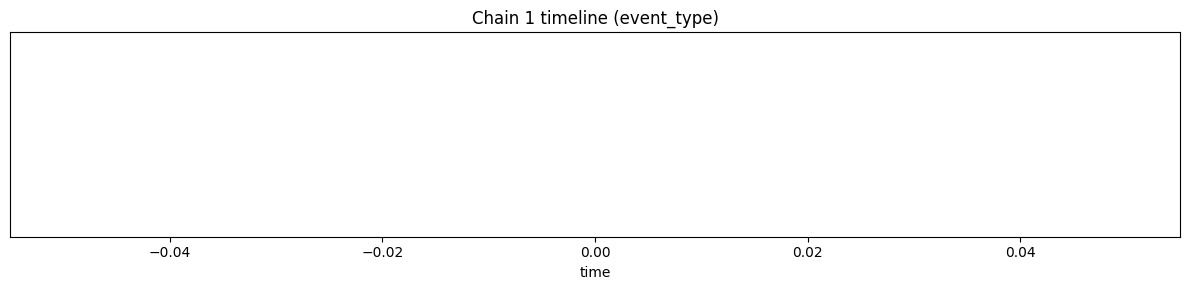

Saved: D:\INS\Assignment_2\results\reconstruction\chain_1_timeline.png


C:\Users\Carol\AppData\Local\Temp\ipykernel_10528\4046134670.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


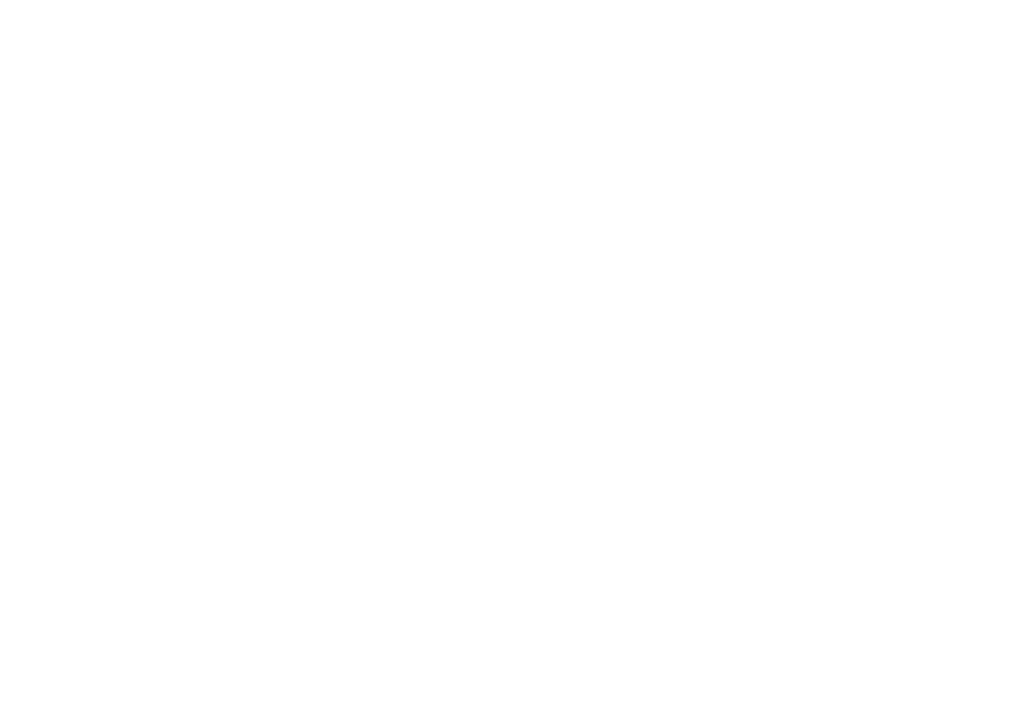

Saved: D:\INS\Assignment_2\results\reconstruction\chain_1_graph.png


In [23]:
# Cell 12 — Deliverable JSON + required visualizations
def chain_to_record(chain_id, event_ids, method, graph=None, score=0.0):
    if not event_ids:
        return None
    t0 = df_work.loc[df_work["event_id"] == event_ids[0], "timestamp"].iloc[0]
    t1 = df_work.loc[df_work["event_id"] == event_ids[-1], "timestamp"].iloc[0]

    evidence = {}
    for eid in event_ids:
        row = df_work.loc[df_work["event_id"] == eid].iloc[0]
        evidence[eid] = {"anomaly_score": float(row.get("anom_score", 0.0))}
    if graph is not None:
        for a, b in zip(event_ids[:-1], event_ids[1:]):
            if graph.has_edge(a, b):
                d = graph[a][b]
                for k in ["weight","s_att","s_time","s_ent"]:
                    if k in d:
                        evidence[b][k] = float(d[k])

    return {
        "chain_id": int(chain_id),
        "events": list(event_ids),
        "start_time": str(t0),
        "end_time": str(t1),
        "method": str(method),
        "score": float(score),
        "evidence": evidence,
    }

recs = [
    chain_to_record(1, path_att, "attention_graph", graph=G_att, score=score_att),
    chain_to_record(2, path_corr, "correlation_graph", graph=G_corr, score=score_corr),
]
recs = [r for r in recs if r is not None]

out_json = RECON_DIR / "reconstructed_chains.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(recs, f, indent=2)
print("Saved:", out_json, "| chains:", len(recs))

# Timeline + graph for chain 1 (required)
chain1 = path_att
chain_df = df_work[df_work["event_id"].isin(chain1)].copy().sort_values("timestamp")

plt.figure(figsize=(12, 3))
plt.scatter(chain_df["timestamp"], range(len(chain_df)))
plt.yticks(range(len(chain_df)), chain_df["event_type"].astype(str).values)
plt.xlabel("time")
plt.title("Chain 1 timeline (event_type)")
plt.tight_layout()
timeline_path = RECON_DIR / "chain_1_timeline.png"
plt.savefig(timeline_path, dpi=200)
plt.show()
print("Saved:", timeline_path)

plt.figure(figsize=(10, 7))
H = G_att.subgraph(chain1).copy()
pos = nx.spring_layout(H, seed=42)
nx.draw(H, pos, with_labels=False, node_size=300, arrows=True)
labels = {n: str(n)[:10] for n in H.nodes}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
graph_path = RECON_DIR / "chain_1_graph.png"
plt.tight_layout()
plt.savefig(graph_path, dpi=200)
plt.show()
print("Saved:", graph_path)


In [24]:
# Example reconstructed chain (required)
import pandas as pd

assert len(recs) > 0, "No reconstructed chains produced."

example_chain = recs[0]
print("Example chain_id:", example_chain["chain_id"])
print("Method:", example_chain["method"])
print("Score:", example_chain["score"])
print("Start:", example_chain["start_time"], "| End:", example_chain["end_time"])

chain_ids = example_chain["events"]
chain_df = df_work[df_work["event_id"].isin(chain_ids)].copy().sort_values("timestamp")

cols = [c for c in ["event_id","timestamp","host","src_ip","dst_ip","user","event_type","attack_stage","label"] if c in chain_df.columns]
display(chain_df[cols])

# show evidence keys for 2-3 events
ev = example_chain.get("evidence", {})
for k in chain_ids[:3]:
    print(k, "->", ev.get(k, {}))


Example chain_id: 2
Method: correlation_graph
Score: 2.4554388406571555
Start: 2025-03-11 02:30:03+00:00 | End: 2025-03-11 04:04:38+00:00


,event_id,timestamp,host,src_ip,dst_ip,user,event_type,attack_stage,label
32983,bdbfe8ea-5e22-46fe-b137-9bf7fbc5889e,2025-03-11 02:30:03+00:00,unknown,61.133.85.187,116.222.129.193,bsmith,firewall,benign,0
32985,b033f6e5-d2d3-4180-b99f-25215886dfaa,2025-03-11 02:40:44+00:00,unknown,34.156.143.39,0.0.0.0,bsmith,ids_alert,recon,1
32992,11e52f2a-17f9-455e-bf81-05dd6e5b6b93,2025-03-11 02:51:39+00:00,unknown,170.124.104.81,0.0.0.0,bsmith,ids_alert,exploit,2
32993,0995efa5-02f7-44d7-8364-38134032fb41,2025-03-11 02:56:16+00:00,unknown,71.251.131.254,150.188.144.63,bsmith,ids_alert,recon,1
32997,341a9b02-5179-4a45-90f1-3008c183691e,2025-03-11 03:08:44+00:00,unknown,10.90.156.55,55.204.102.3,bsmith,ids_alert,benign,0
33005,27f4a667-c694-47fc-bf4f-a55a91e78a7a,2025-03-11 03:27:11+00:00,unknown,119.174.169.130,104.83.158.77,bsmith,firewall,lateral_movement,4
33012,4642f57f-f11c-4673-a19b-fd9719e886bb,2025-03-11 03:43:58+00:00,unknown,0.0.0.0,0.0.0.0,jordan59,cloud,privilege_escalation,3
33014,a383b392-38b3-4094-91c4-e8c149f2b15d,2025-03-11 03:44:31+00:00,unknown,87.95.166.255,0.0.0.0,bsmith,ids_alert,benign,0
33023,4fa10f3a-e089-4464-8d46-dd102d4f88a3,2025-03-11 04:04:38+00:00,unknown,155.95.47.8,0.0.0.0,nancygray,auth,benign,0


bdbfe8ea-5e22-46fe-b137-9bf7fbc5889e -> {'anomaly_score': 0.00010943412780761719}
b033f6e5-d2d3-4180-b99f-25215886dfaa -> {'anomaly_score': 0.38465774059295654, 'weight': 0.310118438280358, 's_att': 0.0, 's_time': 0.7003947942678601, 's_ent': 1.0}
11e52f2a-17f9-455e-bf81-05dd6e5b6b93 -> {'anomaly_score': 0.38449525833129883, 'weight': 0.30849052274958116, 's_att': 0.0, 's_time': 0.6949684091652706, 's_ent': 1.0}
